In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

print('start')
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
# print(rankings['rank_date'].head())
print(rankings.head())
print('\n_______________\n')


matches = pd.read_csv('results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])
print(matches.head())

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
print('stop')

start
   rank country_full country_abrv  cur_year_avg_weighted  rank_date  \
0     1      Germany          GER                    0.0 1993-08-08   
1     2        Italy          ITA                    0.0 1993-08-08   
2     3  Switzerland          SUI                    0.0 1993-08-08   
3     4       Sweden          SWE                    0.0 1993-08-08   
4     5    Argentina          ARG                    0.0 1993-08-08   

   two_year_ago_weighted  three_year_ago_weighted  weighted_points  
0                    0.0                      0.0              0.0  
1                    0.0                      0.0              0.0  
2                    0.0                      0.0              0.0  
3                    0.0                      0.0              0.0  
4                    0.0                      0.0              0.0  

_______________

        date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           

In [2]:
# I want to have the ranks for every day 
print('start')
rankings2=rankings.copy(deep=False)
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# print(rankings.head())
# rankings1=rankings2.set_index(['rank_date'])\
#             .groupby(['country_full'], group_keys=False)\
#     .resample('D').first()\
#     .fillna(method='ffill')\
#     .reset_index()
# print(rankings.head())

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
print(matches.head())
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
print('\n____________________\n')
print(matches.head())
matches_new=matches.copy()

start
        date home_team     away_team  home_score  away_score  \
0 1993-08-08   Bolivia       Uruguay           3           1   
1 1993-08-08    Brazil        Mexico           1           1   
2 1993-08-08   Ecuador     Venezuela           5           0   
3 1993-08-08    Guinea  Sierra Leone           1           0   
4 1993-08-08  Paraguay     Argentina           1           3   

                     tournament      city   country  neutral  rank_date  rank  \
0  FIFA World Cup qualification    La Paz   Bolivia    False 1993-08-08  59.0   
1                      Friendly    Maceió    Brazil    False 1993-08-08   8.0   
2  FIFA World Cup qualification     Quito   Ecuador    False 1993-08-08  35.0   
3                      Friendly   Conakry    Guinea    False 1993-08-08  65.0   
4  FIFA World Cup qualification  Asunción  Paraguay    False 1993-08-08  67.0   

  country_full country_abrv  cur_year_avg_weighted  two_year_ago_weighted  \
0      Bolivia          BOL                  

In [3]:
# feature generation
print('start')
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

start


In [4]:
print(matches_new.columns)
print('\n__________________\n')
matches.head()

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'rank_date_home',
       'rank_home', 'country_full_home', 'country_abrv_home',
       'cur_year_avg_weighted_home', 'two_year_ago_weighted_home',
       'three_year_ago_weighted_home', 'weighted_points_home',
       'rank_date_away', 'rank_away', 'country_full_away', 'country_abrv_away',
       'cur_year_avg_weighted_away', 'two_year_ago_weighted_away',
       'three_year_ago_weighted_away', 'weighted_points_away'],
      dtype='object')

__________________



,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,Portugal,Russia,Saudi Arabia,Senegal,Serbia,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0,0,0,0,0,0,0,0,0,0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,...,0,0,0,0,0,0,0,0,0,0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0,0,0,0,0,0,0,0,0,0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,...,0,0,0,0,0,0,0,0,0,0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(data, features,transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize=(15,15));
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(3, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        #ax.set_ylim((0, 2000))
        #ax.set_yticks([0, 500, 1000, 1500, 2000])
        #ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    #if transformed:
     #   fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
      #      fontsize = 16, y = 1.03)
    #else:
     #   fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
      #      fontsize = 16, y = 1.03)
    
    #fig.tight_layout()
    plt.show()


In [6]:
def sing_distribution(data, feature):    
    fig=plt.hist(data[feature], bins = 25, color = '#00A0A0')
    plt.title("'%s' Feature Distribution"%(feature), fontsize = 14)
    plt.xlabel("Value")
    plt.ylabel("Number of Records")
        
#     fig.show()
    plt.show()


In [112]:
matches=matches.drop(['log_point_difference'], axis=1)

0    [12.1799075267, 4.99853310007, 16.2818329729, ...
1                                             0.552529
dtype: object

___________



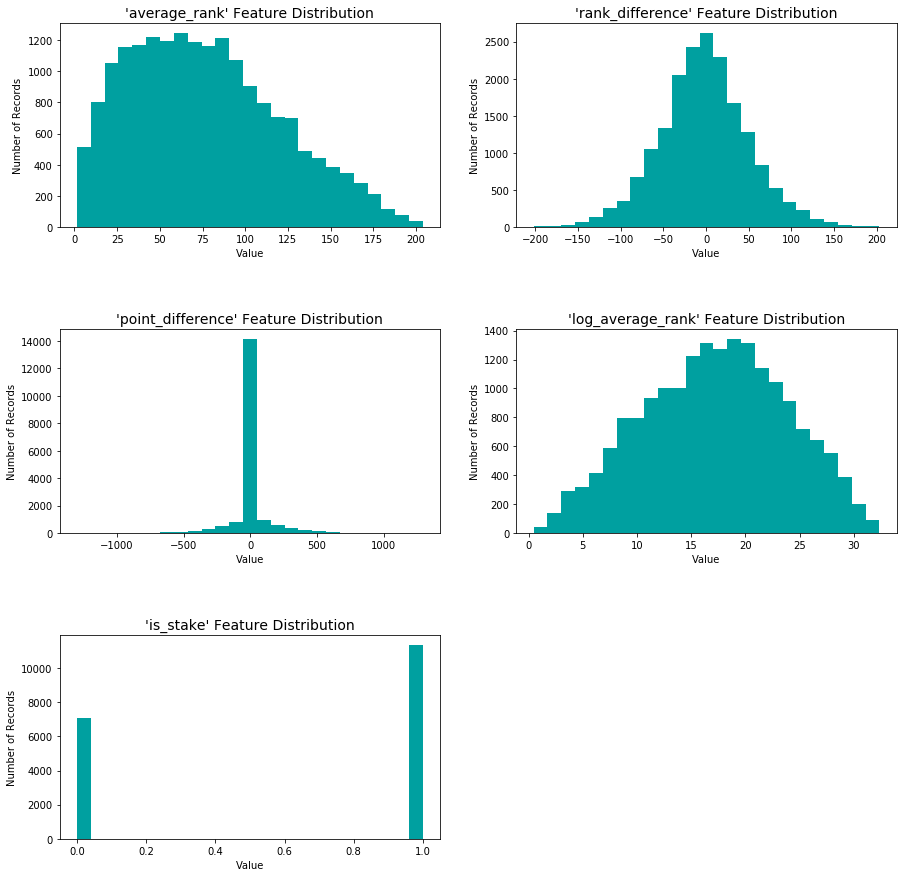

In [7]:
# import visuals as vs
# vs.distribution(matches_new)
# print(matches_new.head())
from scipy.stats import boxcox
data_g=pd.Series(boxcox(matches['average_rank']))
print(data_g)
# aa=pd.DataFrame(data_g[0])
# print(aa.head())
matches['log_average_rank']=data_g[0]
features=['average_rank', 'rank_difference', 'point_difference','log_average_rank','is_stake'];
print('\n___________\n')
distribution(matches,features)

In [8]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# logreg = linear_model.LogisticRegression(C=1e-5)
# features = PolynomialFeatures(degree=2)
# model = Pipeline([
#     ('polynomial_features', features),
#     ('logistic_regression', logreg)
# ])
# model = model.fit(X_train, y_train)

In [9]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['log_average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, f1_score
simpleModel=LogisticRegression()
simpleModel.fit(X_train,y_train)
y_predSimpleModel=simpleModel.predict(X_test)
y_train_pred=simpleModel.predict(X_train)
print('accuracy on training set: ', accuracy_score(y_train, y_train_pred))
print('accuracy on testing set: ', accuracy_score(y_test, y_predSimpleModel))
print('precision on training set: ', fbeta_score(y_train, y_train_pred, beta=1))
print('precision on testing set: ', fbeta_score(y_test, y_predSimpleModel, beta=1))
print(simpleModel.coef_)
print(simpleModel.intercept_ )

accuracy on training set:  0.674626259893
accuracy on testing set:  0.679112554113
precision on training set:  0.655295972481
precision on testing set:  0.661142857143
[[  1.04834245e-02  -1.96534936e-02   4.44014304e-05   6.73683547e-02]]
[-0.33966417]


In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = time()-start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    results['pred_time'] = end-start
            
    results['acc_train'] = accuracy_score(y_train,predictions_train)

    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    results['f_train'] = fbeta_score(y_train,predictions_train,beta=1)
    
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=1)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    print('training set accuracy: ', results['acc_train'])
    print('testing set accuracy: ', results['acc_test'])
    print('fbeta score for training set: ', results['f_train'])
    print('fbeta score for testing set: ', results['f_test'])
    print(learner.get_params())
    print('\n\n')
        
    # Return the results
    return results

In [18]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

classifiers=[DecisionTreeClassifier(random_state=42), 
             AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), random_state=42),
             SVC(kernel="rbf"),
             RandomForestClassifier(),
             GaussianNB()]
clf_A = DecisionTreeClassifier(random_state=42)
clf_B = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), random_state=42)
clf_C = MultinomialNB()
results={}
for i, clf in enumerate(classifiers):
    clf_name=clf.__class__.__name__
    results[clf_name]=train_predict(clf,len(y_train),X_train, y_train,X_test,y_test)


DecisionTreeClassifier trained on 14783 samples.
training set accuracy:  0.960156937022
testing set accuracy:  0.598484848485
fbeta score for training set:  0.957377523699
fbeta score for testing set:  0.587089593767
{'max_depth': None, 'min_samples_leaf': 1, 'class_weight': None, 'presort': False, 'random_state': 42, 'min_samples_split': 2, 'splitter': 'best', 'max_leaf_nodes': None, 'criterion': 'gini', 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'min_impurity_split': 1e-07}



AdaBoostClassifier trained on 14783 samples.
training set accuracy:  0.681390786714
testing set accuracy:  0.665313852814
fbeta score for training set:  0.670352743561
fbeta score for testing set:  0.656102307478
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False,

In [23]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
clf = SVC(kernel="rbf")
parameters={'gamma':[0.00001,0.00005, 0.0001, 0.0002]}
scorer = make_scorer(fbeta_score, beta=1)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, verbose=10)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
print(best_clf)

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 1)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1)))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] gamma=1e-05 .....................................................
[CV] ...................... gamma=1e-05, score=0.643064, total=   4.5s
[CV] gamma=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ...................... gamma=1e-05, score=0.621868, total=   4.6s
[CV] gamma=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s


[CV] ...................... gamma=1e-05, score=0.661339, total=   4.4s
[CV] gamma=5e-05 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s


[CV] ...................... gamma=5e-05, score=0.650770, total=   4.6s
[CV] gamma=5e-05 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.9s remaining:    0.0s


[CV] ...................... gamma=5e-05, score=0.632766, total=   4.6s
[CV] gamma=5e-05 .....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.5s remaining:    0.0s


[CV] ...................... gamma=5e-05, score=0.672799, total=   4.7s
[CV] gamma=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   39.2s remaining:    0.0s


[CV] ..................... gamma=0.0001, score=0.653491, total=   4.9s
[CV] gamma=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.9s remaining:    0.0s


[CV] ..................... gamma=0.0001, score=0.639180, total=   4.9s
[CV] gamma=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.7s remaining:    0.0s


[CV] ..................... gamma=0.0001, score=0.675642, total=   5.0s
[CV] gamma=0.0002 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   59.7s remaining:    0.0s


[CV] ..................... gamma=0.0002, score=0.655224, total=   5.1s
[CV] gamma=0.0002 ....................................................
[CV] ..................... gamma=0.0002, score=0.636144, total=   5.2s
[CV] gamma=0.0002 ....................................................
[CV] ..................... gamma=0.0002, score=0.674679, total=   5.2s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.3min finished


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Unoptimized model
------
Accuracy score on testing data: 0.6328
F-score on testing data: 0.5753

Optimized Model
------
Final accuracy score on the testing data: 0.6810
Final F-score on the testing data: 0.6655
